Notebook demonstrating how excitability changes absent synaptic changes can enable nonlinear computations in neural networks.

# Logic gates in rate-based network

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size


# model params
TAU = 0.01  # membrane time constant (s)
V_0 = -0.06  # leak reversal (V)
V_TH = -0.045  # threshold (V)
B = 1 / 0.001  # sigmoid slope (1/V)
W = 0.01  # synaptic weight (V)

# expt params
INP = {  # test input (V)
    '00': 0.02 * np.array([0, 0]),
    '01': 0.02 * np.array([0, 1]),
    '10': 0.02 * np.array([1, 0]),
    '11': 0.02 * np.array([1, 1]),
}

CTL = {  # external control "current" (V)
    'AND':  np.array([.01,    0, -.01]),  # OUT, E, I
    'OR':   np.array([.01,  .01, -.01]),  # OUT, E, I
    'XOR':  np.array([.01,  .01,    0]),  # ...
    'NAND': np.array([.02, -.01,    0]),
    'NOR':  np.array([.02, -.01,  .01]),
    'XNOR': np.array([.02,    0,  .01]),
}

ORDER_INP = ['00', '01', '10', '11']
ORDER_CTL = ['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR']

# smln params
DT = 0.001  # smln timestep (s)
T_ITVL = 1  # interval between computation switches (s)
T_INP = 0.25  # duration to present each test input

Functions for running smln.

In [2]:
def sgmd(x, th, b):
    """Compute sigmoid function of x given threshold th and slope b."""
    x_ = b * (x - th)
    return 1 / (1 + np.exp(-x_))


class RateNtwk(object):
    
    def __init__(self, n, tau, v_0, v_th, b, w):
        self.n = n
        self.tau = tau
        self.v_0 = v_0
        self.v_th = v_th
        self.b = b
        self.w = w
        
    def run(self, i_ext, dt):
        assert i_ext.shape[1] == self.n
        
        v = np.nan * np.zeros(i_ext.shape)
        r = np.nan * np.zeros(i_ext.shape)
        
        v[0, :] = self.v_0
        r[0, :] = sgmd(v[0, :], self.v_th, self.b)
        
        for ctr in range(1, len(i_ext)):
            i_total_ = -(v[ctr-1, :] - self.v_0) + self.w.dot(r[ctr-1, :]) + i_ext[ctr, :]
            dv = (dt / self.tau) * i_total_
            
            v[ctr, :] = v[ctr-1, :] + dv
            r[ctr, :] = sgmd(v[ctr, :], self.v_th, self.b)
            
        return v, r

Build weight matrix and stimulus.

In [3]:
# binary e/i cxns
c = np.array([
#  IN_A IN_B OUT E   I
    [0,  0,  0,  0,  0],  # IN_A
    [0,  0,  0,  0,  0],  # IN_B
    [0,  0,  0,  1, -1],  # OUT
    [1,  1,  0,  0,  0],  # E
    [1,  1,  0,  0,  0],  # I
])

# weights
w = W * c

# stim
dur_inp = T_INP * len(INP)
dur = T_ITVL * (len(CTL)+1) + dur_inp * len(CTL)  # total smln dur
t = np.arange(0, dur, DT)  # time vec

## i_ext
i_ext = np.zeros((len(t), 5))

### inputs
t_inp = np.arange(0, dur_inp, DT)
i_ext_inp = np.zeros((len(t_inp), 5))

#### make base input
for ctr, key in enumerate(ORDER_INP):
    t_start_idx, t_end_idx = int(np.round((T_INP / DT))) * np.array([ctr, ctr+1])
    i_ext_inp[t_start_idx:t_end_idx, :2] = INP[key]
    
#### add inputs and controls to i_ext
for ctr, key in enumerate(ORDER_CTL):
    t_start_idx = (ctr + 1) * int(np.round(T_ITVL/DT)) + ctr * len(i_ext_inp)
    t_end_idx = t_start_idx + len(i_ext_inp)
    
    # add inputs
    i_ext[t_start_idx:t_end_idx, :] = i_ext_inp.copy()
    
    # add controls
    i_ext[t_start_idx:t_end_idx, 2:] = CTL[key]

Run ntwk.

In [4]:
ntwk = RateNtwk(n=5, tau=TAU, v_0=V_0, v_th=V_TH, b=B, w=w)
v, r = ntwk.run(i_ext, DT)

Plot results.

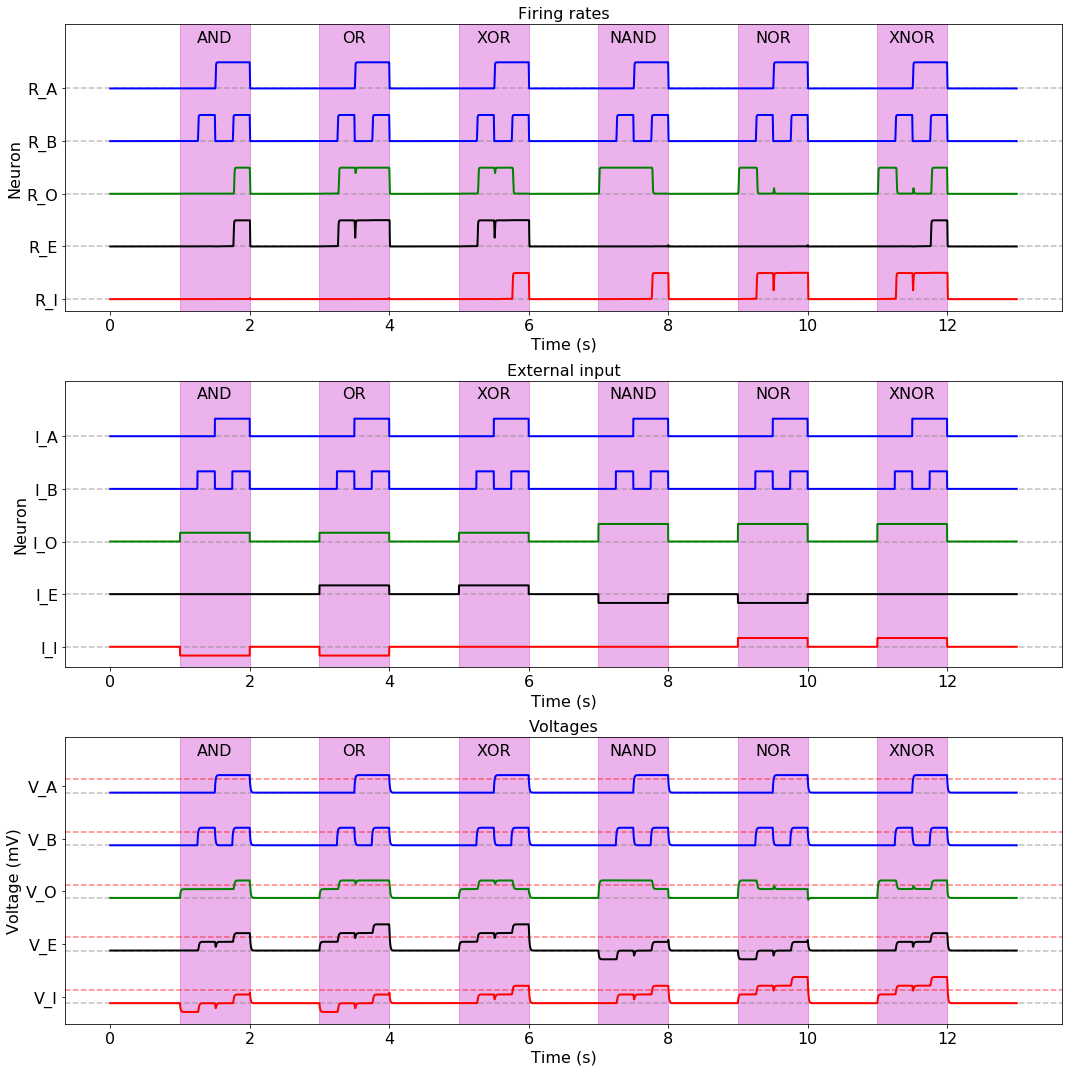

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), tight_layout=True)

# firing rates
colors = ['b', 'b', 'g', 'k', 'r']
y_ticks = []

for ctr, (r_, color) in enumerate(zip(r.T, colors)):
    offset = -ctr * 2
    axs[0].axhline(offset, color='gray', alpha=0.5, ls='--')
    axs[0].plot(t, r_ + offset, color=color, lw=2)
    
    y_ticks.append(offset)

axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels(['R_A', 'R_B', 'R_O', 'R_E', 'R_I'])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Neuron')
axs[0].set_title('Firing rates')

# inputs
colors = ['b', 'b', 'g', 'k', 'r']
y_ticks = []

for ctr, (i, color) in enumerate(zip(i_ext.T, colors)):
    offset = -ctr * 60
    axs[1].axhline(offset, color='gray', alpha=0.5, ls='--')
    axs[1].plot(t, 1000 * i + offset, color=color, lw=2)
    
    y_ticks.append(offset)

axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels(['I_A', 'I_B', 'I_O', 'I_E', 'I_I'])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Neuron')
axs[1].set_title('External input')

# voltages

colors = ['b', 'b', 'g', 'k', 'r']
y_ticks = []

for ctr, (v_, color) in enumerate(zip(v.T, colors)):
    offset = -ctr * 60
    axs[2].axhline(1000 * V_TH + offset, color='r', alpha=0.5, ls='--')
    axs[2].axhline(1000 * V_0 + offset, color='gray', alpha=0.5, ls='--')
    axs[2].plot(t, 1000 * v_ + offset, color=colors[ctr], lw=2)
    
    y_ticks.append(offset + 1000 * .5*(V_0+V_TH))

axs[2].set_yticks(y_ticks)
axs[2].set_yticklabels(['V_A', 'V_B', 'V_O', 'V_E', 'V_I'])
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Voltage (mV)')
axs[2].set_title('Voltages')

for ax in axs:

    # increase y limits to make room for text labels
    y_lim = list(ax.get_ylim())
    y_lim[1] = y_lim[0] + 1.1 * (y_lim[1] - y_lim[0])
    y_range = y_lim[1] - y_lim[0]

    ax.set_ylim(y_lim)
    
    # shade and annotate computational regimes
    for ctr, key in enumerate(ORDER_CTL):
        
        t_start = T_ITVL + ctr * (len(ORDER_INP)*T_INP + T_ITVL)
        t_end = t_start + len(ORDER_INP)*T_INP
        
        # shading
        ax.axvspan(t_start, t_end, color='m', alpha=0.3)
        
        # text
        ax.text(
            .5 * (t_start + t_end), y_lim[1] - .02*y_range, key,
            horizontalalignment='center', verticalalignment='top', fontsize=16)
        
        
    # add labels
    
    set_font_size(ax, 16)